In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings
import logging

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
base_path = "/sfs/gpfs/tardis/home/kcm7zp/brain_tumor_data"

tumor_types = ['glioma', 'meningioma', 'pituitary']
label_map = {'glioma': 1, 'meningioma': 2, 'pituitary': 3}

# print(os.listdir(base_path))

In [3]:
data = []

for tumor in tumor_types:
    img_folder = os.path.join(base_path, tumor, "images")
    mask_folder = os.path.join(base_path, tumor, "masks")
    
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".png") and not f.startswith(".")])
    
    for img_file in tqdm(img_files, desc=f"Processing {tumor}"):
        base_id = img_file.replace(f"{tumor}_", "").replace(".png", "")
        mask_file = f"{tumor}_mask_{base_id}.png"
        
        img_path = os.path.join(img_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        
        # Read in the image and mask 
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Failed to load: {img_path} or {mask_path}")
            continue

        # Resize to common dimensions
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Normalize to [0, 1]
        img = img / 255.0
        mask = mask / 255.0
        
        # Append to data list
        data.append({
            'image': img,
            'mask': mask,
            'label': label_map[tumor]
        })

print(f"\nTotal samples loaded: {len(data)}")


Processing pituitary: 100%|██████████| 930/930 [00:10<00:00, 92.25it/s] 


Total samples loaded: 3064


In [4]:
# Sanity check 
# print(f"Total samples loaded: {len(data)}")

# labels = [item['label'] for item in data]
# unique_labels, counts = np.unique(labels, return_counts=True)
# print("Labels and counts:", dict(zip(unique_labels, counts)))

In [5]:
# Convert to numpy arrays -- run this again
# Skip converting masks right now to save memory
images = np.array([item['image'] for item in data])
# masks = np.array([item['mask'] for item in data])
labels = np.array([item['label'] for item in data])

# Add channel dimension for Tensorflow/Keras 
images = np.expand_dims(images, axis=-1)  # shape: (N, 256, 256, 1)
# masks = np.expand_dims(masks, axis=-1)

In [6]:
# Train/Val/Test Split 
from sklearn.model_selection import train_test_split

# First split off test
X_trainval, X_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.15, stratify=labels, random_state=3402)

# Then split train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, stratify=y_trainval, random_state=3402)

## Build the CNN in Keras

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 tumor classes
])

2025-04-21 13:17:59.081856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 13:17:59.277857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 13:17:59.324012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Compile the Model

In [8]:
# Shift labels to 0-based indexing (1 --> 0, etc.) 
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [9]:
print(X_train.shape) 
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

## Output
# (2213, 256, 256, 1)
# (2213,)
# (array([0, 1, 2]), array([count_0, count_1, count_2]))

(2213, 256, 256, 1)
(2213,)
(array([0, 1, 2]), array([1030,  512,  671]))


In [10]:
print(np.unique(y_train))     # Should output [0 1 2]
print(y_train.shape)          # Should be (N,) — a 1D array
print(y_train[:5])            # Check first few labels


[0 1 2]
(2213,)
[0 1 2 0 1]


In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10


W0000 00:00:1745255885.922607  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.952025  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.969479  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.969951  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.970834  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.971462  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.972530  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.973543  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255885.974720  450245 gp

 1/70 [..............................] - ETA: 3:59 - loss: 1.1179 - accuracy: 0.2188

W0000 00:00:1745255888.125846  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.126295  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.127040  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.127438  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.128175  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.128703  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.129622  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.130506  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.131498  450244 gp

 2/70 [..............................] - ETA: 27s - loss: 1.2912 - accuracy: 0.2969 

W0000 00:00:1745255888.327094  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.329391  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.332149  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.334881  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.336503  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.338555  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.342356  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.344130  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.348621  450244 gp

 4/70 [>.............................] - ETA: 13s - loss: 1.4635 - accuracy: 0.2891

W0000 00:00:1745255888.534010  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.534994  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.535968  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.537413  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.538825  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.539878  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.540778  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.541741  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.543274  450242 gp

14/70 [=====>........................] - ETA: 3s - loss: 1.1196 - accuracy: 0.4219

W0000 00:00:1745255888.734814  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.736265  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.737339  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.738250  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.739230  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.740752  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.742290  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.743956  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255888.745924  450244 gp

70/70 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7076

W0000 00:00:1745255889.802138  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.802278  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.802435  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.802541  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.802695  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.802820  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.803000  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.803174  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255889.803369  450244 gp

70/70 [==============================] - 6s 32ms/step - loss: 0.6337 - accuracy: 0.7076 - val_loss: 0.3395 - val_accuracy: 0.8542
Epoch 2/10
 9/70 [==>...........................] - ETA: 0s - loss: 0.3542 - accuracy: 0.8507

W0000 00:00:1745255890.289692  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.289860  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.290057  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.290181  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.290375  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.290530  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.290771  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.291002  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255890.291256  450243 gp

70/70 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8861

W0000 00:00:1745255891.400776  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.400932  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401090  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401196  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401350  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401474  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401652  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.401825  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.402020  450245 gp

70/70 [==============================] - 1s 19ms/step - loss: 0.2881 - accuracy: 0.8861 - val_loss: 0.2833 - val_accuracy: 0.8747
Epoch 3/10
 9/70 [==>...........................] - ETA: 0s - loss: 0.1973 - accuracy: 0.9306

W0000 00:00:1745255891.606663  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.606937  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.607192  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.607550  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.607903  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.608181  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.608408  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.608668  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255891.609089  450242 gp

70/70 [==============================] - 1s 17ms/step - loss: 0.1930 - accuracy: 0.9200 - val_loss: 0.2625 - val_accuracy: 0.8900
Epoch 4/10
 5/70 [=>............................] - ETA: 1s - loss: 0.0961 - accuracy: 0.9625

W0000 00:00:1745255892.701408  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.701618  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.701782  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.701946  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.702116  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.702274  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.702404  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.702647  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255892.702850  450243 gp

70/70 [==============================] - 1s 17ms/step - loss: 0.1023 - accuracy: 0.9580 - val_loss: 0.3076 - val_accuracy: 0.9130
Epoch 5/10
 5/70 [=>............................] - ETA: 1s - loss: 0.0549 - accuracy: 0.9812

W0000 00:00:1745255893.924572  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.924782  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.924943  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.925105  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.925272  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.925429  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.925556  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.925799  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255893.926006  450243 gp

70/70 [==============================] - 1s 17ms/step - loss: 0.0526 - accuracy: 0.9806 - val_loss: 0.3064 - val_accuracy: 0.8900
Epoch 6/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0301 - accuracy: 0.9883 - val_loss: 0.3703 - val_accuracy: 0.8875
Epoch 7/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0202 - accuracy: 0.9950 - val_loss: 0.5339 - val_accuracy: 0.9105
Epoch 8/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.4769 - val_accuracy: 0.8977
Epoch 9/10
70/70 [==============================] - 1s 17ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4571 - val_accuracy: 0.9105
Epoch 10/10
70/70 [==============================] - 1s 17ms/step - loss: 6.3961e-04 - accuracy: 1.0000 - val_loss: 0.5063 - val_accuracy: 0.9028


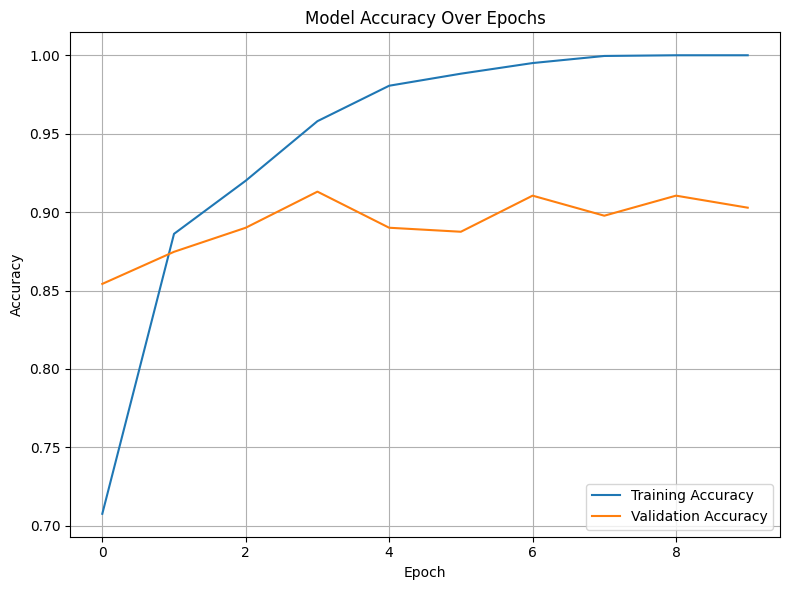

In [12]:
# Visualize accuracy over each epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluate the Model

In [13]:
from sklearn.metrics import classification_report
import numpy as np

warnings.filterwarnings("ignore")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Flatten true labels if necessary
y_true = y_test.flatten()

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Meningioma', 'Glioma', 'Pituitary']))

15/15 [==============================] - 0s 9ms/step - loss: 0.3194 - accuracy: 0.9283

Test Accuracy: 0.93


W0000 00:00:1745255902.015716  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.015941  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.016248  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.016425  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.016724  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.016952  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.017321  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.017679  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.018086  450242 gp

15/15 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

  Meningioma       0.94      0.93      0.93       214
      Glioma       0.85      0.87      0.86       106
   Pituitary       0.97      0.97      0.97       140

    accuracy                           0.93       460
   macro avg       0.92      0.92      0.92       460
weighted avg       0.93      0.93      0.93       460



W0000 00:00:1745255902.367185  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.367406  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.367719  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.367896  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.368204  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.368434  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.368804  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.369159  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255902.369568  450242 gp

## Hyperparameter Tuning

In [14]:
# ! pip install keras-tuner --upgrade

In [15]:
# import keras
# from keras import layers, models

# def build_model(hp):
#     model = models.Sequential()

#     # Input for grayscale 256x256
#     model.add(layers.Input(shape=(256, 256, 1)))

#     # Convolutional blocks
#     for i in range(hp.Int("conv_blocks", 1, 3)):
#         model.add(layers.Conv2D(
#             filters=hp.Int(f"filters_{i}", 32, 128, step=32),
#             kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5]),
#             activation="relu",
#             padding="same"
#         ))
#         model.add(layers.MaxPooling2D(pool_size=2))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(
#         hp.Int("dense_units", 64, 256, step=64),
#         activation="relu"
#     ))
#     model.add(layers.Dropout(hp.Float("dropout_rate", 0.2, 0.5, step=0.1)))
#     model.add(layers.Dense(3, activation="softmax"))

#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
#         ),
#         loss="sparse_categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     return model


### Define builder function

In [16]:
import keras
from keras import layers, models

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=X_train.shape[1:]
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Initialize tuner

In [17]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="keras_tuner_dir",
    project_name="brain_tumor_tuning"
)

Reloading Tuner from keras_tuner_dir/brain_tumor_tuning/tuner0.json


### Run the search for best hyperparameters

In [18]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [19]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# print("Best hyperparameters:")
# print(f"Filters: {best_hps.get('filters')}")
# print(f"Kernel Size: {best_hps.get('kernel_size')}")
# print(f"Dense Units: {best_hps.get('units')}")
print("Available hyperparameters:")
print(best_hps.values)

Available hyperparameters:
{'conv_blocks': 2, 'filters_0': 96, 'kernel_size_0': 3, 'dense_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00011678341253394451, 'filters_1': 64, 'kernel_size_1': 3}


### Rebuild Model with Best Hyperparameters 

In [20]:
# Rebuild the model with the best hyperparameters
model = tf.keras.Sequential()

# First convolutional block
model.add(tf.keras.layers.Conv2D(
    filters=best_hps.get('filters_0'),
    kernel_size=best_hps.get('kernel_size_0'),
    activation='relu',
    input_shape=X_train.shape[1:]
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(tf.keras.layers.Conv2D(
    filters=best_hps.get('filters_1'),
    kernel_size=best_hps.get('kernel_size_1'),
    activation='relu'
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=best_hps.get('dense_units'),
    activation='relu'
))
model.add(tf.keras.layers.Dropout(best_hps.get('dropout_rate')))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile with best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the final model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10


W0000 00:00:1745255904.582142  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.583462  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.584568  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.585681  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.586958  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.589880  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.592313  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.594743  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255904.597343  450242 gp

 1/70 [..............................] - ETA: 2:57 - loss: 1.0854 - accuracy: 0.4062

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1745255906.270759  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.272061  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.273160  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.274269  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.275421  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.278231  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.280386  450242 gpu_timer.cc:114] Skipping

 3/70 [>.............................] - ETA: 26s - loss: 1.5383 - accuracy: 0.3125

W0000 00:00:1745255906.894482  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.895778  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.896881  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.897993  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.899159  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.901963  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.904125  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.906290  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255906.908579  450243 gp

 5/70 [=>............................] - ETA: 16s - loss: 1.4842 - accuracy: 0.3063

W0000 00:00:1745255907.101434  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.104382  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.107463  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.110174  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.113238  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.117775  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.120567  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.125068  450242 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255907.127740  450242 gp

70/70 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.6864

W0000 00:00:1745255909.187080  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.187377  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.187597  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.187815  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.188060  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.188600  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.188991  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.189381  450245 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.189823  450245 gp

70/70 [==============================] - 6s 51ms/step - loss: 0.7013 - accuracy: 0.6864 - val_loss: 0.3866 - val_accuracy: 0.8568
Epoch 2/10
 3/70 [>.............................] - ETA: 1s - loss: 0.3902 - accuracy: 0.8542

W0000 00:00:1745255909.694211  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.694566  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.694854  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.695139  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.695443  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.696132  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.696651  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.697170  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255909.697741  450244 gp

70/70 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8789

W0000 00:00:1745255911.810916  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.812078  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.812615  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.813180  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.813723  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.814268  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.814835  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.815400  450244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255911.815938  450244 gp

70/70 [==============================] - 2s 33ms/step - loss: 0.3166 - accuracy: 0.8789 - val_loss: 0.2928 - val_accuracy: 0.8849
Epoch 3/10
70/70 [==============================] - 2s 32ms/step - loss: 0.2153 - accuracy: 0.9128 - val_loss: 0.2528 - val_accuracy: 0.8849
Epoch 4/10
70/70 [==============================] - 2s 32ms/step - loss: 0.1353 - accuracy: 0.9480 - val_loss: 0.2583 - val_accuracy: 0.8721
Epoch 5/10
70/70 [==============================] - 2s 32ms/step - loss: 0.0782 - accuracy: 0.9788 - val_loss: 0.2313 - val_accuracy: 0.8951
Epoch 6/10
70/70 [==============================] - 2s 32ms/step - loss: 0.0525 - accuracy: 0.9855 - val_loss: 0.2619 - val_accuracy: 0.8977
Epoch 7/10
70/70 [==============================] - 2s 32ms/step - loss: 0.0317 - accuracy: 0.9973 - val_loss: 0.2476 - val_accuracy: 0.8977
Epoch 8/10
70/70 [==============================] - 2s 32ms/step - loss: 0.0180 - accuracy: 0.9986 - val_loss: 0.2406 - val_accuracy: 0.9105
Epoch 9/10
70/70 [======

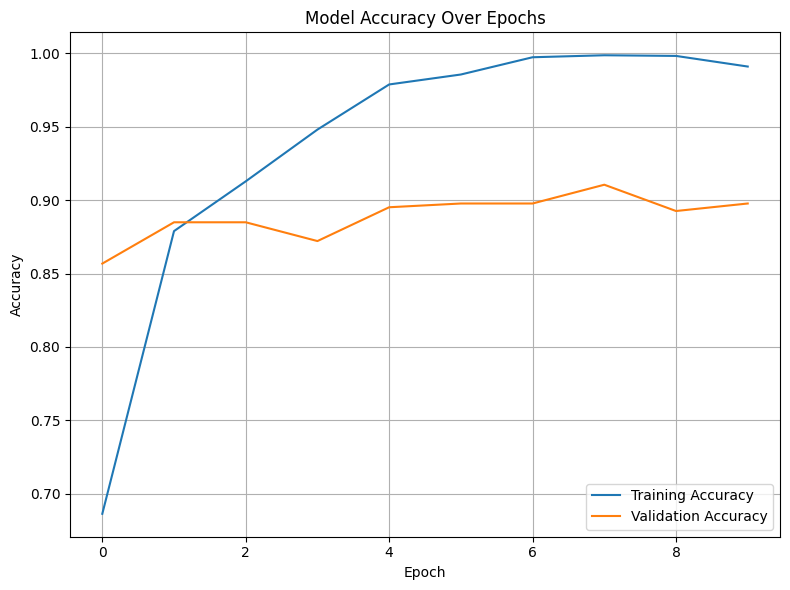

In [21]:
# Visualize accuracy over each epoch
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Try 15 epochs

Epoch 1/15
70/70 [==============================] - 2s 34ms/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.2565 - val_accuracy: 0.8977
Epoch 2/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.2525 - val_accuracy: 0.9028
Epoch 3/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2679 - val_accuracy: 0.9028
Epoch 4/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 0.8926
Epoch 5/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 0.2705 - val_accuracy: 0.9028
Epoch 6/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2729 - val_accuracy: 0.9054
Epoch 7/15
70/70 [==============================] - 2s 32ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9054
Epoch 8/15
70

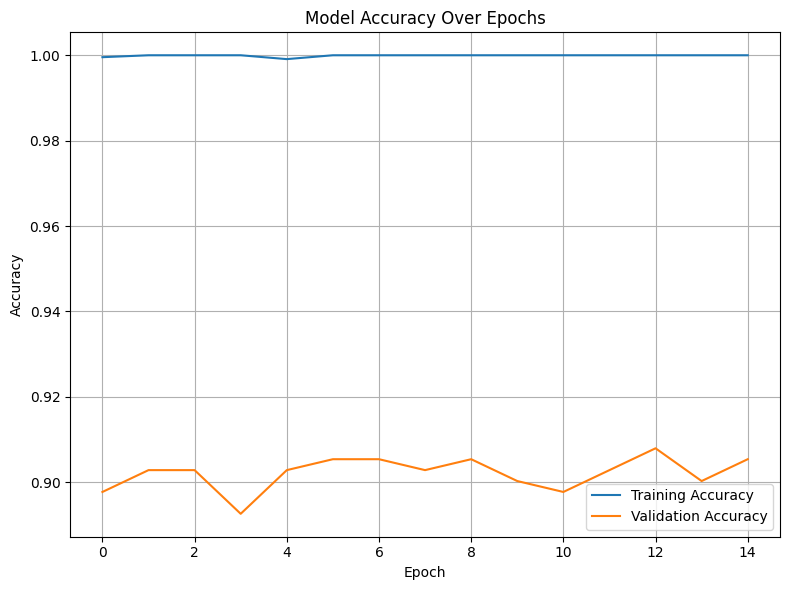

In [22]:
# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)

 
# Visualize accuracy over each epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate the model

In [23]:
from sklearn.metrics import classification_report
import numpy as np

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Flatten true labels if necessary
y_true = y_test.flatten()

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Meningioma', 'Glioma', 'Pituitary']))

15/15 [==============================] - 0s 16ms/step - loss: 0.2972 - accuracy: 0.9109

Test Accuracy: 0.91


W0000 00:00:1745255964.794271  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.794842  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.795292  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.795745  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.796251  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.797368  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.798231  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.799113  450243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745255964.800069  450243 gp

15/15 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

  Meningioma       0.94      0.89      0.91       214
      Glioma       0.80      0.85      0.83       106
   Pituitary       0.96      0.99      0.97       140

    accuracy                           0.91       460
   macro avg       0.90      0.91      0.90       460
weighted avg       0.91      0.91      0.91       460



## Save the model from the best-performing epoch

### Build the model

In [24]:
# Rebuild the model with the best hyperparameters
model = tf.keras.Sequential()

# First convolutional block
model.add(tf.keras.layers.Conv2D(
    filters=best_hps.get('filters_0'),
    kernel_size=best_hps.get('kernel_size_0'),
    activation='relu',
    input_shape=X_train.shape[1:]
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(tf.keras.layers.Conv2D(
    filters=best_hps.get('filters_1'),
    kernel_size=best_hps.get('kernel_size_1'),
    activation='relu'
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=best_hps.get('dense_units'),
    activation='relu'
))
model.add(tf.keras.layers.Dropout(best_hps.get('dropout_rate')))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile with best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the final model
# history = model.fit(
#     X_train, y_train,
#     epochs=10,
#     validation_data=(X_val, y_val)
# )

### Fit the model 

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

model.fit(X_train, y_train,
          epochs=15,
          validation_data=(X_val, y_val),
          callbacks=[checkpoint])


Epoch 1/15


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

 5/70 [=>............................] - ETA: 1s - loss: 1.3170 - accuracy: 0.4812

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


69/70 [============================>.] - ETA: 0s - loss: 0.6791 - accuracy: 0.7142
Epoch 1: val_accuracy improved from -inf to 0.86189, saving model to best_model.h5
70/70 [==============================] - 4s 41ms/step - loss: 0.6781 - accuracy: 0.7149 - val_loss: 0.3894 - val_accuracy: 0.8619
Epoch 2/15
69/70 [============================>.] - ETA: 0s - loss: 0.3180 - accuracy: 0.8850
Epoch 2: val_accuracy improved from 0.86189 to 0.88491, saving model to best_model.h5
70/70 [==============================] - 3s 37ms/step - loss: 0.3186 - accuracy: 0.8848 - val_loss: 0.2821 - val_accuracy: 0.8849
Epoch 3/15
69/70 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9235
Epoch 3: val_accuracy did not improve from 0.88491
70/70 [==============================] - 2s 32ms/step - loss: 0.2121 - accuracy: 0.9236 - val_loss: 0.3226 - val_accuracy: 0.8849
Epoch 4/15
69/70 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9457
Epoch 4: val_accuracy imp

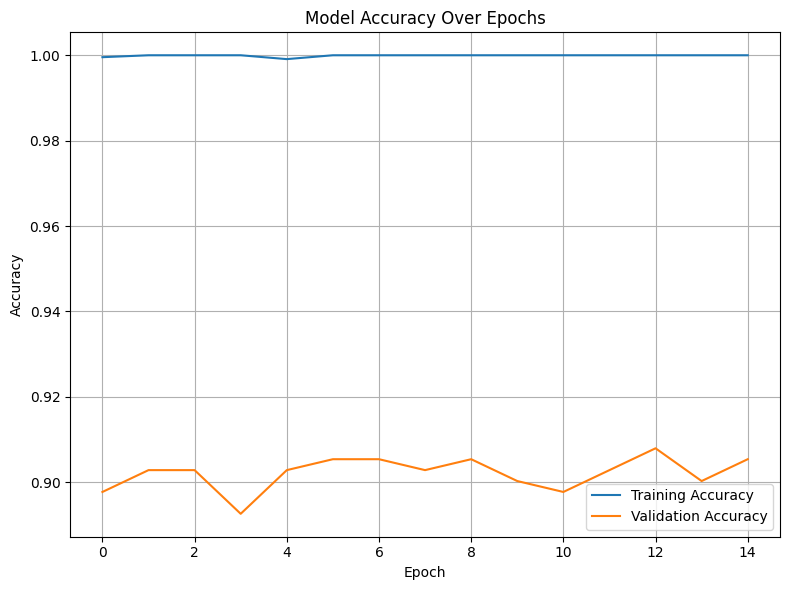

In [27]:
# Visualize accuracy over each epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate the model

In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Get the best model
model.load_weights('best_model.h5')
model.evaluate(X_val, y_val)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.2f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Flatten true labels if necessary
y_true = y_test.flatten()

# Print classification report
print(classification_report(y_true, y_pred, target_names=['Meningioma', 'Glioma', 'Pituitary']))

15/15 [==============================] - 0s 11ms/step - loss: 0.2275 - accuracy: 0.9022

Test Accuracy: 0.90
15/15 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

  Meningioma       0.93      0.89      0.91       214
      Glioma       0.79      0.82      0.81       106
   Pituitary       0.95      0.98      0.96       140

    accuracy                           0.90       460
   macro avg       0.89      0.90      0.89       460
weighted avg       0.90      0.90      0.90       460

